In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from mediapipe import solutions

from utils import smooth_data, split_data
from video_converter import Video2DataFrame
from custom_pose_landmarks import CustomPoseLandmark
from model_builder import RNN
from loss import RMSELoss
from engine import train
from data_setup import create_dataloaders

In [4]:
# Prepare paths
data_path = '../data/'
video_path = os.path.join(data_path, 'raw/squat')

# Read personal data from excel
personal_data = pd.read_excel(os.path.join(data_path, 'PersonalData.xlsx'))

# Processed data path
processed_data = os.path.join(data_path, 'processed')

In [4]:
# Selected values of pose landmarks corresponding to PoseLandmark class from MediaPipe library
values = [0, 11, 12, 13, 14, 15, 16, 19, 20, 23, 24, 25, 26, 27, 28, 31, 32]

# Custom pose landmark names and their connections
landmarks = {
    'THORAX': ['NOSE'],
    'PELVIS': ['LEFT_HIP', 'RIGHT_HIP'],}

# MediaPipe solutions
mp_drawing = solutions.drawing_utils
mp_pose = solutions.pose

custom_pose = CustomPoseLandmark(mp_pose, values, landmarks)
conv = Video2DataFrame(mp_pose, mp_drawing, custom_pose)

In [ ]:
converter = Video2DataFrame(mp_pose, mp_drawing, custom_pose)

# Convert videos to dataframe
dataframe = converter.get_dataframe(
    source=video_path,
    detection=0.9,
    tracking=0.9,
    video_display=False
)

In [5]:
# Save dataframe
# dataframe.to_csv('ConvertedSquats.csv', index=False)

# Load dataframe
dataframe = pd.read_csv(os.path.join(processed_data, 'ConvertedSquats.csv'))

In [ ]:
# Canonical form code
default_hip_width = 1
default_pelvis = np.zeros(shape=(3,))

transformed_data = pd.DataFrame()

for _, file_data in dataframe.groupby(by='FileId'):
    # Extract starting pose coordinates
    starting_pose = file_data.iloc[0]

    # Z-axis normalization procedure
    left_hip = starting_pose.filter(regex='LeftHip').to_numpy()
    right_hip = starting_pose.filter(regex='RightHip').to_numpy()

    left_knee = starting_pose.filter(regex='LeftKnee').to_numpy()
    right_knee = starting_pose.filter(regex='RightKnee').to_numpy()

    left_thigh_length = np.linalg.norm(left_hip - left_knee)
    right_thigh_length = np.linalg.norm(right_hip - right_knee)

    mean_length = np.mean([left_thigh_length, right_thigh_length])

    # Normalization
    to_normalize = file_data.filter(regex='Z$')
    # min_z = to_normalize.min()
    # max_z = to_normalize.max()

    # normalized = 2 * mean_length * (to_normalize - min_z) / (max_z - min_z) - mean_length
    normalized = mean_length * to_normalize

    file_data = file_data.assign(**normalized)


    # Extract starting pose coordinates
    starting_pose = file_data.iloc[0]
    
    # Translation procedure
    pelvis = starting_pose.filter(regex='Pelvis').to_numpy()

    translation_vector = default_pelvis - pelvis

    # Scaling procedure
    left_hip = starting_pose.filter(regex='LeftHip').to_numpy()
    right_hip = starting_pose.filter(regex='RightHip').to_numpy()

    hip_vector = left_hip - right_hip
    hip_width = np.linalg.norm(hip_vector)

    scale_factor = default_hip_width / hip_width

    # Transformation
    to_transform = file_data.filter(regex='X$|Y$|Z$')

    transformed = scale_factor * (
        to_transform + np.tile(translation_vector, len(to_transform.columns) // 3)
    )

    file_data = file_data.assign(**transformed)
    transformed_data = pd.concat([transformed_data, file_data])

dataframe = transformed_data.copy()

In [ ]:
# Merge personal and video data
data = pd.merge(dataframe, personal_data, on='Id')

# Calculate the maximum load that was passed
max_load = data.loc[data['Lifted'] == 1, ['Id', 'Load']].groupby(by='Id', as_index=False).max()
max_load = max_load.rename(columns={'Load': 'MaxLoad'})
data = pd.merge(data, max_load, on='Id')

# Calculate what percentage of the maximum load is the current load
data['PercentageMaxLoad'] = 100 * data['Load'] / data['MaxLoad']

del data['MaxLoad']

# Get only lifted approaches
data = data.loc[data['Lifted'] == 1]

# Variables that aren't needed in the first run
to_drop = [
    'Id', 'Age', 'Height', 'Weight', 'PastInjuries', 'LastInjury', 'PainDuringTraining', 'SquatRecord',
    'BenchPressRecord', 'DeadliftRecord', 'PhysicalActivities', 'SetNumber', 'Load', 'Lifted', 'Timestamp']

data = data.drop(columns=to_drop)

# Categorical variables that need to be one hot encoded
to_one_hot = [
    'ProficiencyLevel', 'EquipmentAvailability', 'TrainingProgram', 'TrainingFrequency', 'CameraPosition']

data = pd.get_dummies(data, columns=to_one_hot, dtype=int)

# Move the PercentageMaxLoad column to the end of the dataframe
percentage = data.pop('PercentageMaxLoad')
data['PercentageMaxLoad'] = percentage

# Smooth all features extracted from MediaPipe solution
data = smooth_data(data, frac=0.1, it=3)

In [3]:
# Save dataframe
# data.to_csv(os.path.join(processed_data, 'OneRepMaxData_250324.csv'), index=False)

# Load dataframe
data = pd.read_csv(os.path.join(processed_data, 'OneRepMaxData_240324.csv'))

In [4]:
# Get dictionary of file ids assingned to different datasets
file_ids = split_data(data, [0.8, 0.15, 0.05])

# Setup hyperparameters
BATCH_SIZE = 128
NUM_WORKERS = 0
PIN_MEMORY = True

train_dataloader, valid_dataloader, test_dataloader = create_dataloaders(
    data=data,
    file_ids=file_ids,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

In [5]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Setup hyperparameters
INPUT_SIZE = 78
HIDDEN_SIZE = 512
NUM_LAYERS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize RNN model class instance
model = RNN(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS)

# Send model to device
model = model.to(device=DEVICE)

In [8]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = RMSELoss()

In [9]:
results = train(model, train_dataloader, valid_dataloader, optimizer, loss_fn, NUM_EPOCHS, DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

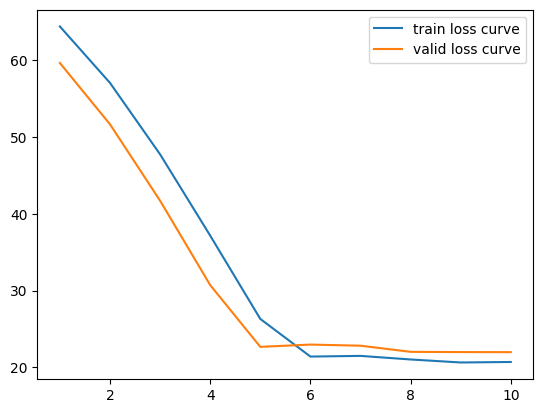

In [10]:
plt.plot(range(1, NUM_EPOCHS + 1), results['train_loss']);
plt.plot(range(1, NUM_EPOCHS + 1), results['valid_loss']);
plt.legend(['train loss curve', 'valid loss curve'])

In [11]:
# Put model in evaluation mode
model.eval()

# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for data, targets in train_dataloader:
        # Send data to target device
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate and accumulate loss
        loss = loss_fn(targets, predictions)

In [12]:
pd.DataFrame({'targets': targets.cpu().squeeze(), 'predictions': predictions.cpu().squeeze()}, index=range(len(targets.cpu())))

,targets,predictions
0,56.250000,62.501072
1,60.000000,62.501072
2,69.444443,62.501072
3,67.741936,62.501072
4,16.129032,62.501072
5,77.272728,62.501072
6,100.000000,62.501072
7,72.727272,62.501072
8,76.086960,62.501072
9,88.888885,62.501072
